# Here, nothing should be going on (just reading in the data and plotting it) so you can skip this part (you should still run it though)

In [18]:
#imports

import numpy as np
import matplotlib.pyplot as plt
from alt_period_finder import alt_period_finder
plt.style.use('seaborn-dark-palette')
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
import butcher1 as butcher
from astropy.timeseries import LombScargle
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import modeling
from tqdm import tqdm

import scipy.optimize as op
import os
import emcee
import corner
import time

%matplotlib inline

import emcee


font = {'family':'normal', 'weight':'bold', 'size':36}
plt.rc('font', **font)

In [19]:
#reading in the data

#AAVSO 'HMB' data
#aavso_data = ascii.read('aavso.csv')
#hmb_mask = (aavso_data['mag'] > np.mean(aavso_data['mag'])-2*np.std(aavso_data['mag']))*(aavso_data['emag'] < 0.05)
#hmb_data = aavso_data[hmb_mask]

#hmb_flux = butcher.mag_to_flux(hmb_data['mag'])
#hmb_eflux = butcher.emag_to_eflux(hmb_data['emag'], hmb_data['emag'])

#ASAS data
orgasas_data = ascii.read('asas.csv')
asas_mask = (orgasas_data['mag'] > np.mean(orgasas_data['mag'])-2*np.std(orgasas_data['mag']))*(orgasas_data['emag'] < 0.05)
asas_data = orgasas_data[asas_mask]

asas_flux = butcher.mag_to_flux(asas_data['mag'])
asas_eflux = butcher.emag_to_eflux(asas_data['mag'], asas_data['emag'])

#ASASSN data
orgasassn_data = ascii.read('asassn.csv')
asassn_mask = (orgasassn_data['mag'] > np.mean(orgasassn_data['mag'])-2*np.std(orgasassn_data['mag']))*(orgasassn_data['emag'] < 0.05)
asassn_data = orgasassn_data[asassn_mask]

asassn_flux = butcher.mag_to_flux(asassn_data['mag'])
asassn_eflux = butcher.emag_to_eflux(asassn_data['mag'], asassn_data['emag'])

#KELT data
orgkelt_data = ascii.read('kelt.csv')
kelt_mask = (orgkelt_data['mag'] > np.mean(orgkelt_data['mag'])-2*np.std(orgkelt_data['mag']))*(orgkelt_data['emag'] < 0.05)
kelt_data = orgkelt_data[kelt_mask]

kelt_flux = butcher.mag_to_flux(kelt_data['mag'])
kelt_eflux = butcher.emag_to_eflux(kelt_data['mag'], kelt_data['emag'])

#PROMPT data
orgprompt_data = ascii.read('prompt.csv') #time is JD-2450000
prompt_mask = (orgprompt_data['mag'] > np.mean(orgprompt_data['mag'])-2*np.std(orgprompt_data['mag']))*(orgprompt_data['emag'] < 0.05)
prompt_data = orgprompt_data[prompt_mask]

prompt_flux = butcher.mag_to_flux(prompt_data['mag'])
prompt_eflux = butcher.emag_to_eflux(prompt_data['mag'], prompt_data['emag'])

#ROAD data
orgroad_data = ascii.read('road_new.csv') #time is JD-2450000
road_mask = (orgroad_data['mag'] > np.mean(orgroad_data['mag'])-2*np.std(orgroad_data['mag']))*(orgroad_data['emag'] < 0.05)
road_data = orgroad_data[road_mask]

road_flux = butcher.mag_to_flux(road_data['mag'])
road_eflux = butcher.emag_to_eflux(road_data['mag'], road_data['emag'])

In [20]:
print(np.min(road_data['HJD']), np.max(road_data['HJD']), len(road_data))

56105.96175 58971.00105 3569


In [21]:
import astropy.units as u
def fit_sine(time, period, comb_sigma):
    
    def sine(x, period, a, b, d):
        #Creates a sine curve with parameters a, b, d but with fixed c (period)
        return a+b*np.sin((2*np.pi/period)*(x-d))
    
    #Fit a sine curve with this set period
    popt, pcov = curve_fit(sine, time, periods, p0 = [period, 3.2, 0.03, 56750], sigma=comb_sigma, absolute_sigma = True)
    return popt, pcov

def fit_sine2(time, period, fluxes, comb_sigma):
    
    def sine(x, period, a, b, d):
        #Creates a sine curve with parameters a, b, d but with fixed c (period)
        return a+b*np.sin((2*np.pi/period)*(x-d))
    
    #Fit a sine curve with this set period
    popt, pcov = curve_fit(sine, time, fluxes, p0 = [period, 3.2, 0.03, 56750], sigma=comb_sigma, absolute_sigma = True)
    return popt, pcov

def sine(x, period, a, b, d):
    #print(np.max((2*np.pi/period)*(x-d)))
    #print(np.min((2*np.pi/period)*(x-d)))
   
    return a+b*np.sin(((2*np.pi/period)*(x-d))*u.radian)

In [22]:
#
































#

In [23]:
#hmb_flux = butcher.long_correct(hmb_data['HJD'], hmb_flux, hmb_eflux)
asas_flux = butcher.long_correct(asas_data['MJD'], asas_flux, asas_eflux)
asassn_flux = butcher.long_correct(asassn_data['MJD'], asassn_flux, asassn_eflux)
kelt_flux = butcher.long_correct(kelt_data['HJD'], kelt_flux, kelt_eflux)
prompt_flux = butcher.long_correct(prompt_data['HJD'], prompt_flux, prompt_eflux)
road_flux = butcher.long_correct(road_data['HJD'], road_flux, road_eflux)

## LombScargle per dataset

In [24]:
def binner(bins, time, flux):
    means, errors = [], []
    midpoints = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    for i in range(len(bins)-1):
        binned_mask = (time < bins[i+1])*(time > bins[i])
        means.append(np.mean(flux[binned_mask]))
        errors.append(np.std(flux[binned_mask])/np.sqrt(len(flux[binned_mask])))
    return means, errors, midpoints

In [25]:
times = [asas_data['MJD'], asassn_data['MJD'], kelt_data['HJD'], prompt_data['HJD'], road_data['HJD']]
fluxes = [asas_flux, asassn_flux, kelt_flux, prompt_flux, road_flux]
uncertainties = [asas_eflux, asassn_eflux, kelt_eflux, prompt_eflux, road_eflux]
names = ['ASAS', 'ASAS-SN', 'KELT', 'PROMPT', 'ROAD']
periods=np.linspace(1.5,5, 500)

#fig, ax = plt.subplots(5, 2)

font = {'family':'normal', 'weight':'bold', 'size':8}
plt.rc('font', **font)


for i in range(5):
    yes = True
    if yes:
        pass
    else:
        
        time, flux, uncertainty = times[i], fluxes[i], uncertainties[i]
        frequency, power = LombScargle(time, flux-np.mean(flux), uncertainty).autopower(minimum_frequency=1/(np.max(periods)), maximum_frequency=1/(np.min(periods)), samples_per_peak=10)

        maximum_power = 1/np.max(frequency[np.where(power == np.max(power))[0]])

        ax[i, 0].plot(1/frequency, power, label = names[i] + ', Maximum Period: ' + '{0:.3f}'.format(maximum_power) + ' days')
        if i == 4:
            ax[i, 0].set_xlabel('Periodicity of the signal (Days)')
        ax[i, 0].set_ylabel('Power of the signal')
        ax[i, 0].axvline(x = 0.5*maximum_power, linestyle = '--', c = 'r', label = '0.5 times Maximum Period', alpha = 0.3)
        ax[i, 0].legend()

        means, errors, midpoints = binner(np.linspace(0, maximum_power, 50), time%(maximum_power), flux)
        ax[i, 1].errorbar(midpoints, means/np.mean(flux), errors, fmt = '.')

        popt, pcov = curve_fit(sine, midpoints, means/np.mean(flux), p0 = [maximum_power, 1, 0.03, 2.1], sigma=errors, absolute_sigma = True)
        print(np.diag(np.sqrt(pcov))[0])
        print('amp ', popt[2])

        sine_space = np.linspace(0, maximum_power*3, 500)

        ax[i, 1].plot(sine_space, sine(sine_space, popt[0], popt[1], popt[2], popt[3]), label = names[i] + ', Best sine with period: '+str(popt[0])[:5] + ' days')
        ax[i, 1].axhline(y = 1, linestyle = '--', c= 'grey', label = 'Mean')
        ax[i, 1].set_ylim(0.95, 1.05)
        ax[i, 1].legend()
        if i == 4:
            ax[i, 1].set_xlabel('Folded Period (Days)')
        ax[i, 1].set_ylabel('Mean Flux')

        print(np.min(time), np.max(time))
    
    
    
#fig = plt.gcf()
#fig.set_size_inches(10,10)
#plt.savefig('LombScargle_&_Sinefit.pdf')
#plt.show()

In [26]:
#
































#

In [27]:
#corr_hmb, p1 = butcher.short_correct(hmb_data['HJD'], hmb_flux, hmb_eflux)
corr_asas, p2 = butcher.short_correct(asas_data['MJD'], asas_flux, asas_eflux)
corr_asassn, p3 = butcher.short_correct(asassn_data['MJD'], asassn_flux, asassn_eflux)
corr_kelt, p4 = butcher.short_correct(kelt_data['HJD'], kelt_flux, kelt_eflux)
corr_prompt, p6 = butcher.short_correct(prompt_data['HJD'], prompt_flux, prompt_eflux)
corr_road, p5 = butcher.short_correct(road_data['HJD'], road_flux, road_eflux)

In [28]:
#Adding the uncorrected data:
all_times = np.concatenate((np.array(asas_data['MJD']), np.array(asassn_data['MJD']), np.array(kelt_data['HJD']), np.array(prompt_data['HJD']), np.array(road_data['HJD']))) #np.array(hmb_data['HJD']),
all_flux = np.concatenate((np.array(asas_flux), np.array(asassn_flux), np.array(kelt_flux), np.array(prompt_flux), np.array(road_flux))) #np.array(hmb_flux),
all_eflux = np.concatenate((np.array(asas_eflux), np.array(asassn_eflux), np.array(kelt_eflux), np.array(prompt_eflux), np.array(road_eflux))) #np.array(hmb_eflux)

all_flux_short = np.concatenate((np.array(corr_asas), np.array(corr_asassn), np.array(corr_kelt), np.array(corr_prompt), np.array(corr_road))) #np.array(corr_hmb),
alt_flux_short, p555 = butcher.short_correct(all_times, all_flux, all_eflux)
print(alt_flux_short)
all_times_final, all_flux_final, all_flux_short_final, all_eflux_final = zip(*sorted(zip(all_times, all_flux, alt_flux_short, all_eflux)))

all_times_final = np.array(all_times_final)
all_flux_final = np.array(all_flux_final)
all_flux_short_final = np.array(all_flux_short_final)
all_eflux_final = np.array(all_eflux_final)
print(all_flux_short_final)
atf, aff, afsf, aef = np.zeros(len(all_times_final)), np.zeros(len(all_times_final)), np.zeros(len(all_times_final)), np.zeros(len(all_times_final))
atf[:], aff[:], afsf[:], aef[:] = all_times_final, all_flux_final, all_flux_short_final, all_eflux_final

print(len(atf))

#from numpy import savetxt
#savetxt('final_comb_data_S.csv', final_array, delimiter=',')
#savetxt('final_comb_flux.csv', flux_final, delimiter=',')
#savetxt('final_comb_eflux.csv', eflux_final, delimiter=',')


[1.04795002 1.06388697 1.06201668 ... 1.02185177 1.04462175 1.00329167]
[1.04795002 1.06388697 1.06201668 ... 1.02185177 1.04462175 1.00329167]
10785


[51887.35963 51900.34297 51903.34678 ... 58970.0014  58971.00066
 58971.00105] [1.04795002 1.06388697 1.06201668 ... 1.02185177 1.04462175 1.00329167] [0.02340865 0.0189794  0.01938555 ... 0.00861462 0.00794107 0.00787551]


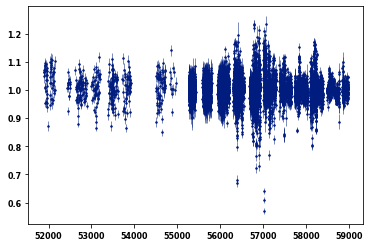

In [29]:
#all_flux_short = np.concatenate((np.array(corr_hmb),np.array(corr_asas),np.array(corr_asassn),np.array(corr_kelt),np.array(corr_prompt),np.array(corr_road)))
print(all_times_final, all_flux_short_final, all_eflux_final)
#all_times = np.concatenate(all_times)
#all_eflux = np.concatenate(all_eflux)
plt.errorbar(all_times_final, all_flux_short_final, yerr=all_eflux_final, fmt='.', ms=3, elinewidth=0.5)
plt.show()

## The cell below creates the average_rotation periods (sep_periods) and the respective epochs (sep_midpoints)

51900.34  days.
52026.15  days.
52442.03  days.
52635.34  days.
52700.33  days.
52782.11  days.
53003.35  days.
53071.30  days.
53391.34  days.
53465.25  days.
53544.00  days.
53727.35  days.
53796.29  days.
54504.34  days.
54578.31  days.
54827.35  days.
0 0
56809.11  days.
57017.35  days.
57094.16  days.
57233.06  days.
57390.37  days.
57560.05  days.
57758.35  days.
57833.34  days.
57913.18  days.
58123.35  days.
58309.19  days.
0 0
3.224 & 0.004 & 55267 & 55338 \\
3.200 & 0.017 & 55569 & 55622 \\
3.213 & 0.005 & 55645 & 55718 \\
3.183 & 0.010 & 55932 & 56004 \\
3.183 & 0.004 & 56422 & 56485 \\
3.198 & 0.012 & 56669 & 56731 \\
3.204 & 0.005 & 56743 & 56808 \\
3.241 & 0.015 & 56811 & 56884 \\
8 8
57227.17  days.
3.233 & 0.021 & 57435 & 57499 \\
3.206 & 0.051 & 57796 & 57841 \\
3.222 & 0.028 & 56855 & 56924 \\
2 3
3.195 & 0.008 & 56480 & 56550 \\
3.214 & 0.010 & 56686 & 56760 \\
3.187 & 0.009 & 56761 & 56835 \\
3.228 & 0.011 & 57011 & 57085 \\
3.228 & 0.007 & 57162 & 57235 \\
3.228 & 

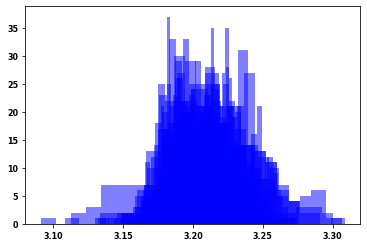

In [30]:
#Seperate for each data set:
times = [asas_data['MJD'], asassn_data['MJD'], kelt_data['HJD'], prompt_data['HJD'], road_data['HJD']] #hmb_data['HJD'], 
fluxes = [asas_flux, asassn_flux, kelt_flux, prompt_flux, road_flux] #hmb_flux, 
efluxes = [asas_eflux, asassn_eflux, kelt_eflux, prompt_eflux, road_eflux] #hmb_eflux, 

sep_midpoints = []
sep_periods = []
sep_errors = []

sample_sizes = [75, 75, 75, 75, 75]
points_per_cycles = [2.5, 2.5, 2.5, 2.5, 2.5]

for i in range(5):
    alt_comb_midpoints = []
    alt_comb_periods = []
    alt_comb_errors = []
    
    midpoints, chunk_periods, errors = alt_period_finder(times[i], fluxes[i], efluxes[i], sample_size = sample_sizes[i], points_per_cycle = points_per_cycles[i])
    for k in chunk_periods:
        alt_comb_periods.append(k)
    for l in midpoints:
        alt_comb_midpoints.append(l)
    for m in errors:
        alt_comb_errors.append(m)
            
    alt_comb_midpoints = np.array(alt_comb_midpoints)
    alt_comb_periods = np.array(alt_comb_periods)
    alt_comb_errors = np.array(alt_comb_errors).astype(np.float)

    alt_better_mask = (alt_comb_periods < 3.29) * (alt_comb_periods > 3.11) * (alt_comb_errors < 0.05)
    
    true = 0
    for i in range(len(alt_better_mask)):
        if alt_better_mask[i] == True:
            true +=1
    print(true, len(alt_better_mask))
    sep_midpoints.append(alt_comb_midpoints[alt_better_mask])
    sep_periods.append(alt_comb_periods[alt_better_mask])
    sep_errors.append(alt_comb_errors[alt_better_mask])
    
combined_midpoints = np.concatenate(sep_midpoints)

## Mention:

-de 0.05 error
-de 75 dagen
-de 3 punten per cyclus
-de jump masks

[array([], dtype=float64), array([], dtype=float64), array([55298.0952715, 55619.056851 , 55663.92832  , 55981.063927 ,
       56443.7819095, 56717.943632 , 56774.8698465, 56836.7202265]), array([57461.227737, 56885.057031]), array([56513.96788 , 56722.40637 , 56794.98346 , 57046.38787 ,
       57193.98935 , 57409.39215 , 57483.26235 , 57560.22321 ,
       57750.38087 , 57829.878575, 57885.99502 , 58117.380335,
       58196.401795, 58269.15991 , 58348.49703 , 58533.40017 ,
       58562.40179 , 58637.00079 , 58710.98175 , 58862.38819 ,
       58950.38145 ])]


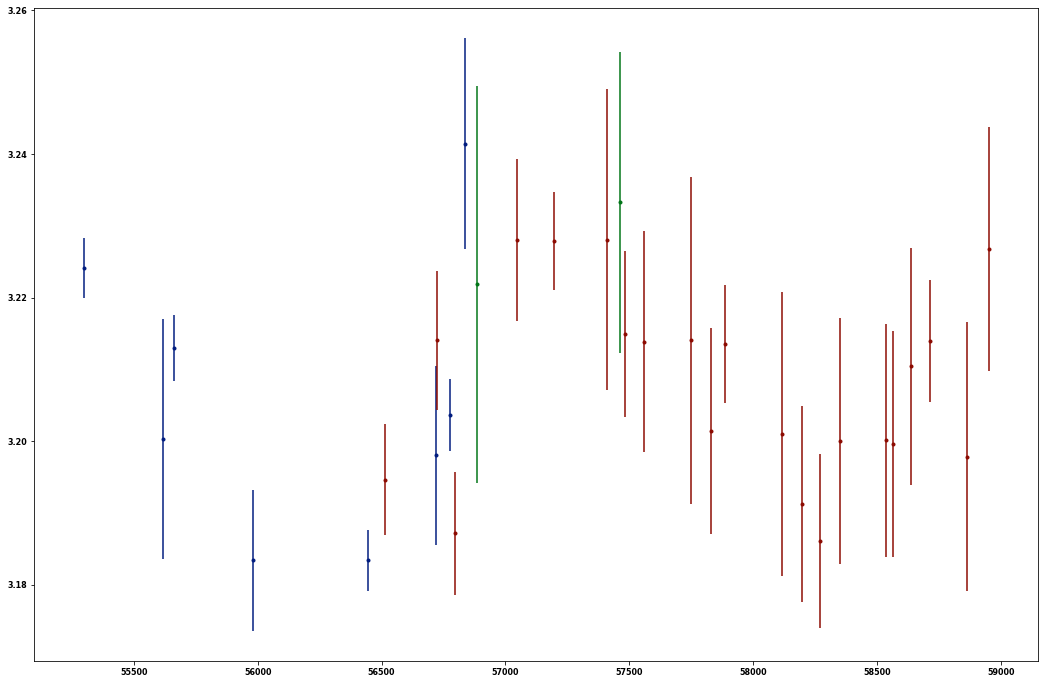

31


In [31]:
print(sep_midpoints)

names = ['ASAS', 'ASASSN', 'KELT', 'PROMPT', 'ROAD'] #'AAVSO', 
for i in range(5):
    if len(sep_midpoints[i]) != 0:#ASASSN does not yield any periods
        plt.errorbar(sep_midpoints[i], sep_periods[i], sep_errors[i], fmt='.')
    
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.xlim(np.min(combined_midpoints)-200, np.max(combined_midpoints) + 200)
#plt.ylim(3.1, 3.3)
#plt.savefig("75_days_3ppc_33result.pdf")
plt.show()


print(len(combined_midpoints))

## The three cells below are our pre-emcee method of determining the cycle_period. They also create the masks to omit the odd jumps. Besides this it should be fine to just run them once

C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


3.2080219519522
[3.20579320e+00 3.20416465e+00 1.98016573e-02 5.67508987e+04] [[ 4.97120302e-07  3.57589071e-08 -1.12488400e-06 -2.18236667e-04]
 [ 3.57589071e-08  1.52101337e-05 -1.45894218e-05 -8.98097827e-05]
 [-1.12488400e-06 -1.45894218e-05  3.67785974e-05  6.44487639e-04]
 [-2.18236667e-04 -8.98097827e-05  6.44487639e-04  1.07527534e-01]]


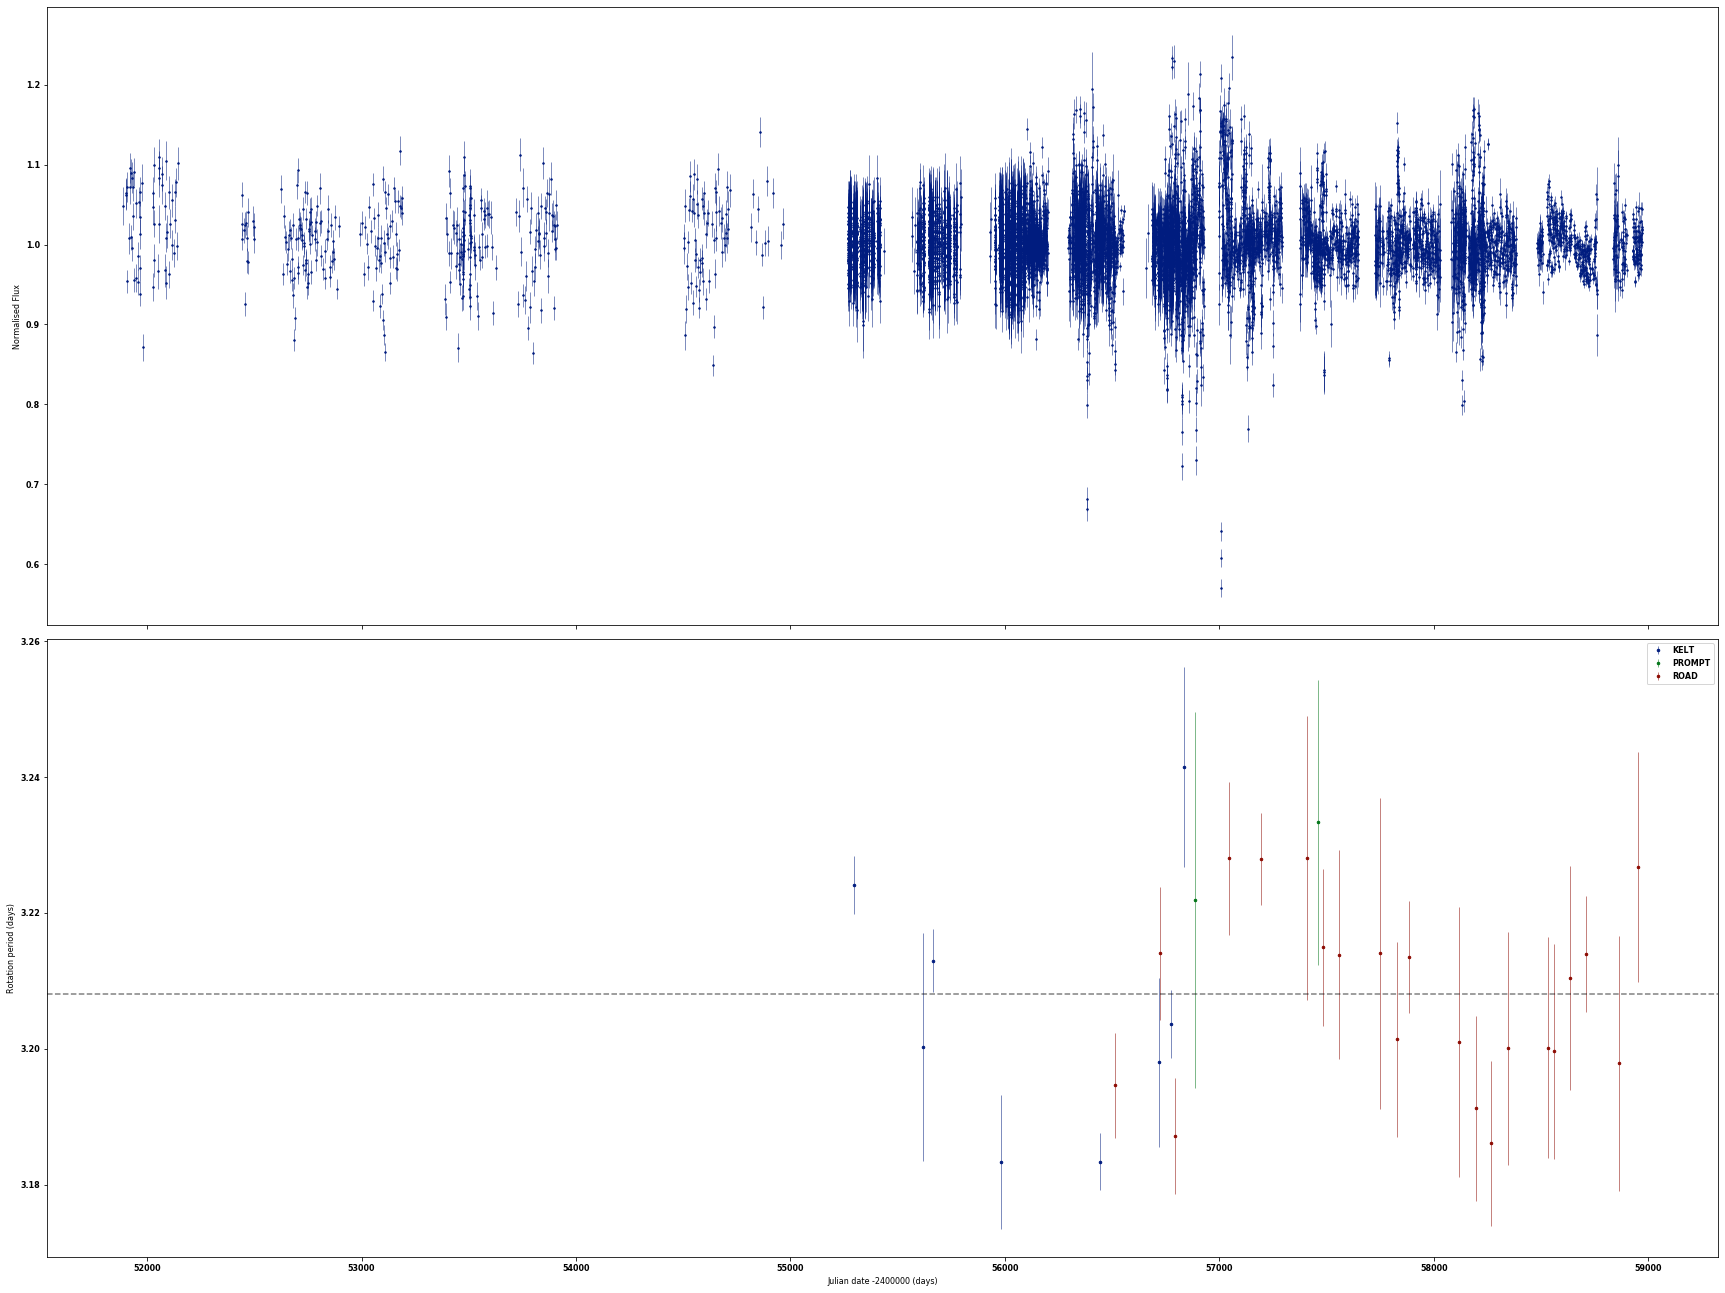

In [32]:
names = ['ASAS', 'ASASSN', 'KELT', 'PROMPT', 'ROAD'] #'AAVSO', 

fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)

for i in range(5):
    if sep_midpoints[i] != []: #ASASSN does not yield any periods
        axs[1].errorbar(sep_midpoints[i], sep_periods[i], yerr=sep_errors[i], fmt='.', ms=5, elinewidth=0.5, label=names[i])

combined_midpoints = np.concatenate(sep_midpoints)
combined_periods = np.concatenate(sep_periods)
combined_errors = np.concatenate(sep_errors)

combined_masky = (combined_errors <  0.02) * (combined_midpoints > 57000)

average_period = np.average(sep_periods[-1], weights=sep_errors[-1])
print(average_period)
popt=fit_sine2(combined_midpoints[combined_masky], average_period, combined_periods[combined_masky], combined_errors[combined_masky])


axs[0].errorbar(all_times_final, all_flux_short_final, yerr=all_eflux_final, fmt='.', ms=3, elinewidth=0.5)
#axs[1].plot(np.linspace(np.min(combined_midpoints), np.max(combined_midpoints), 1000), sine(np.linspace(np.min(combined_midpoints), np.max(combined_midpoints), 1000), *popt), color='red', alpha=0.6, label='fit ['+str(popt[0])[:7]+"   "+str(popt[1])[:6]+"   "+str(popt[2])[:6]+']')
print(*popt)
figure = plt.gcf()
figure.set_size_inches(24, 18)
axs[1].axhline(average_period, color='black', alpha=0.5, ls='--')
axs[1].set_xlabel('Julian date -2400000 (days)')
axs[1].set_ylabel('Rotation period (days)')
axs[0].set_ylabel('Normalised Flux')
#plt.xlim(55000, 59000)
plt.legend()
#plt.savefig('lightcurve_and_variability.png')
plt.show()

C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


3.207528204529286 3.2053459795162444 0.010223371859343912 56749.93992707483


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


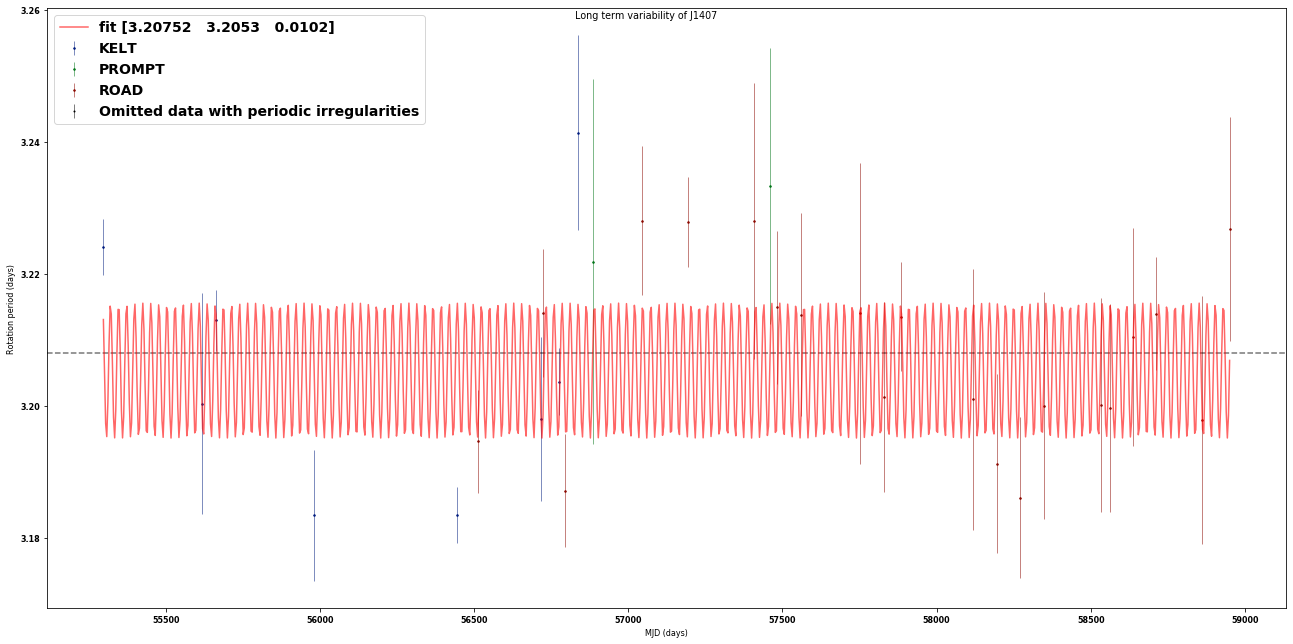

In [33]:
#We are going to remove the chunks which show odd periodic effects (4)
fig, axs = plt.subplots(1, 1, sharex=True, tight_layout=True)

#mask1 = (combined_midpoints > 55200) * (combined_midpoints < 55500)
#mask2 = (combined_midpoints > 55900) * (combined_midpoints < 56250)
#mask3 = (combined_midpoints > 57000) * (combined_midpoints < 57350)
#mask4 = (combined_midpoints > 57750) * (combined_midpoints < 58050)
#mask5 = (combined_midpoints < 55000 )

mask6 = combined_periods < 3.17
bad_fit_mask = mask6#mask5 + mask1 + mask2 + mask3 
good_fit_mask = np.invert(bad_fit_mask)
names = ['ASAS', 'ASASSN', 'KELT', 'PROMPT', 'ROAD'] #'AAVSO', 

#axs[0].errorbar(all_times_final, all_flux_short_final, yerr=all_eflux_final, fmt='.', ms=3, elinewidth=0.5)
#axs[0].axhline(np.mean(all_flux_short_final), color='black', alpha=0.3, ls='--')

for i in range(5):
    if sep_midpoints[i] != []: #ASASSN does not yield any periods
        axs.errorbar(sep_midpoints[i], sep_periods[i], yerr=sep_errors[i], fmt='.', ms=3, elinewidth=0.5, label=names[i])
        #axs[1].legend()
axs.axhline(average_period, color='black', alpha=0.3, ls='--')
axs.legend(fontsize=14, loc='upper left')

popt, pcov =fit_sine2(combined_midpoints[good_fit_mask], average_period, combined_periods[good_fit_mask], combined_errors[good_fit_mask])#combined_errors[good_fit_mask])
axs.plot(np.linspace(np.min(combined_midpoints[good_fit_mask]), np.max(combined_midpoints[good_fit_mask]), 1000), sine(np.linspace(np.min(combined_midpoints[good_fit_mask]), np.max(combined_midpoints[good_fit_mask]), 1000), *popt), color='red', zorder=20, alpha=0.6, label='fit ['+str(popt[0])[:7]+"   "+str(popt[1])[:6]+"   "+str(popt[2])[:6]+']')
#axs[1].errorbar(combined_midpoints[good_fit_mask], combined_periods[good_fit_mask], yerr=combined_errors[good_fit_mask], fmt='.', ms=3, elinewidth=0.5, label='Combined data used for fit')
axs.errorbar(combined_midpoints[bad_fit_mask], combined_periods[bad_fit_mask], yerr=combined_errors[bad_fit_mask], fmt='.', ms=2, elinewidth=0.5, color='black', alpha=1, label='Omitted data with periodic irregularities')
axs.axhline(average_period, color='black', alpha=0.3, ls='--')

print(*popt)
figure = plt.gcf()
figure.set_size_inches(18, 9)
axs.set_xlabel('MJD (days)')
axs.set_ylabel('Rotation period (days)')
axs.set_ylabel('Rotation period (days)')
#axs[0].set_ylabel('Normalised flux')
plt.legend(fontsize=14, loc='upper left')
plt.suptitle('Long term variability of J1407')
#plt.savefig('75_days_3ppc_33result_fit_with_prev_mask.pdf')
plt.show()

## Below the emcee starts, which follows the exact same proces as the notebook you sent

In [34]:
x_data = combined_midpoints[good_fit_mask]
y_data = combined_periods[good_fit_mask]
y_err = combined_errors[good_fit_mask]

time_space = np.linspace(np.min(x_data)-100, np.max(x_data)+100, 5000)

x_data, y_data, y_err = zip(*sorted(zip(x_data, y_data, y_err)))
 
###par =    [2350,         55700,       3.2,      0.015] #Guess based on previous results
par =    [1950,         56800,       3.2,      0.018] #Guess based on previous results

labels = ["$P_{act}$", "$t_0$", "$P_{mean}$", "$a$"]

In [35]:
def activity_model(t, P, t0, mean, a):
    P_activity = mean + a * np.sin(2*np.pi * (t-t0)/P) 
    return P_activity

In [36]:
Pact_model = activity_model(time_space, 2350, 55700, 3.20, 0.015)

In [37]:
def lnlike(theta, t, f, ferr):
    ''' theta holds the free parameters of the model, t,f, ferr are the noisy observed measurements'''
    P, t0, mean, a = theta

    # calculate the model with the values in theta, and the data in (t,f,ferr)
    model = activity_model(t, P, t0, mean, a)
    
    # calculate the chi squared for each epoch
    chi2 = np.power((f-model)/ferr,2.)
    
    # add up all the chi squareds, and the -0.5 is for emcee
    #print(-0.5*(np.sum(chi2)))
    return -0.5*(np.sum(chi2))


# this nll function is for the minimise function, which wants a MINIMISE a value, not maximise it.
nll = lambda *args: -lnlike(*args)

In [38]:
result = op.minimize(nll, par, method='nelder-mead', args=(x_data,y_data,y_err),
                     options={'maxiter':10000,'xtol': 1e-8, 'disp': True})

print(result)

Optimization terminated successfully.
         Current function value: 12.548896
         Iterations: 189
         Function evaluations: 373
 final_simplex: (array([[1.96278606e+03, 5.67759487e+04, 3.20587934e+00, 1.97156344e-02],
       [1.96278606e+03, 5.67759487e+04, 3.20587934e+00, 1.97156344e-02],
       [1.96278606e+03, 5.67759487e+04, 3.20587934e+00, 1.97156344e-02],
       [1.96278606e+03, 5.67759487e+04, 3.20587934e+00, 1.97156344e-02],
       [1.96278606e+03, 5.67759487e+04, 3.20587934e+00, 1.97156344e-02]]), array([12.54889598, 12.54889598, 12.54889598, 12.54889598, 12.54889598]))
           fun: 12.548895980424067
       message: 'Optimization terminated successfully.'
          nfev: 373
           nit: 189
        status: 0
       success: True
             x: array([1.96278606e+03, 5.67759487e+04, 3.20587934e+00, 1.97156344e-02])


In [39]:
# prior - here we choose whether to restrict the fitting paramaters
def lnprior(theta):
    P, t0, mean, a = theta
    if 500 < P < 3000 and 3.10 < mean < 3.3:
        return 0.0
    return -np.inf

In [40]:
def lnprob(theta, t, f, ferr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, f, ferr)

In [41]:
ndim, nwalkers = 4, 100

# we can add the parameters found in the LWFIT above:
par = result.x

pos = [par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_data,y_data,y_err), threads=4)

In [43]:
#start = time.time()
pos, prob, state = sampler.run_mcmc(pos, 15000)
#end = time.time()
#print(end-start)

In [44]:
# save the chains to file
#np.savez_compressed('chains.npz', sampler.chain, sampler.lnprobability)

In [45]:
print(sampler.get_autocorr_time(c=1))
print(sampler.acceptance_fraction)

[36.80621399 36.69343383 36.89523604 36.93682163]
[0.595      0.59566667 0.5968     0.5898     0.59393333 0.59786667
 0.59186667 0.5926     0.5888     0.59486667 0.5928     0.5944
 0.59466667 0.60206667 0.59686667 0.59426667 0.58306667 0.59313333
 0.58946667 0.58493333 0.59053333 0.59333333 0.59146667 0.59413333
 0.592      0.59233333 0.58873333 0.5932     0.59366667 0.58853333
 0.58713333 0.591      0.59626667 0.5906     0.5964     0.5978
 0.60106667 0.59366667 0.5928     0.58726667 0.5946     0.59226667
 0.5948     0.59353333 0.59466667 0.5944     0.5912     0.59866667
 0.5972     0.59113333 0.59786667 0.59566667 0.59293333 0.5986
 0.59893333 0.59533333 0.58973333 0.5962     0.586      0.5948
 0.5878     0.59553333 0.59893333 0.59593333 0.60086667 0.599
 0.58333333 0.59166667 0.59573333 0.59026667 0.59606667 0.6
 0.5924     0.59726667 0.59433333 0.58566667 0.59806667 0.59966667
 0.59566667 0.5954     0.59646667 0.58886667 0.59373333 0.5914
 0.58873333 0.58846667 0.59213333 0.59046667

In [46]:
burn = 600
print(sampler.chain.shape)
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))
print(samples.shape)

(100, 15000, 4)
(1440000, 4)


In [47]:
#fig, ax = plt.subplots(ndim,ndim, figsize=(12,12))
#fig = corner.corner(samples, labels=labels, show_titles=False, fig=fig)
#fig.savefig("emcee_triangle_3.pdf")

In [48]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [49]:
print(q)

[0.00244365 0.00246934]


C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


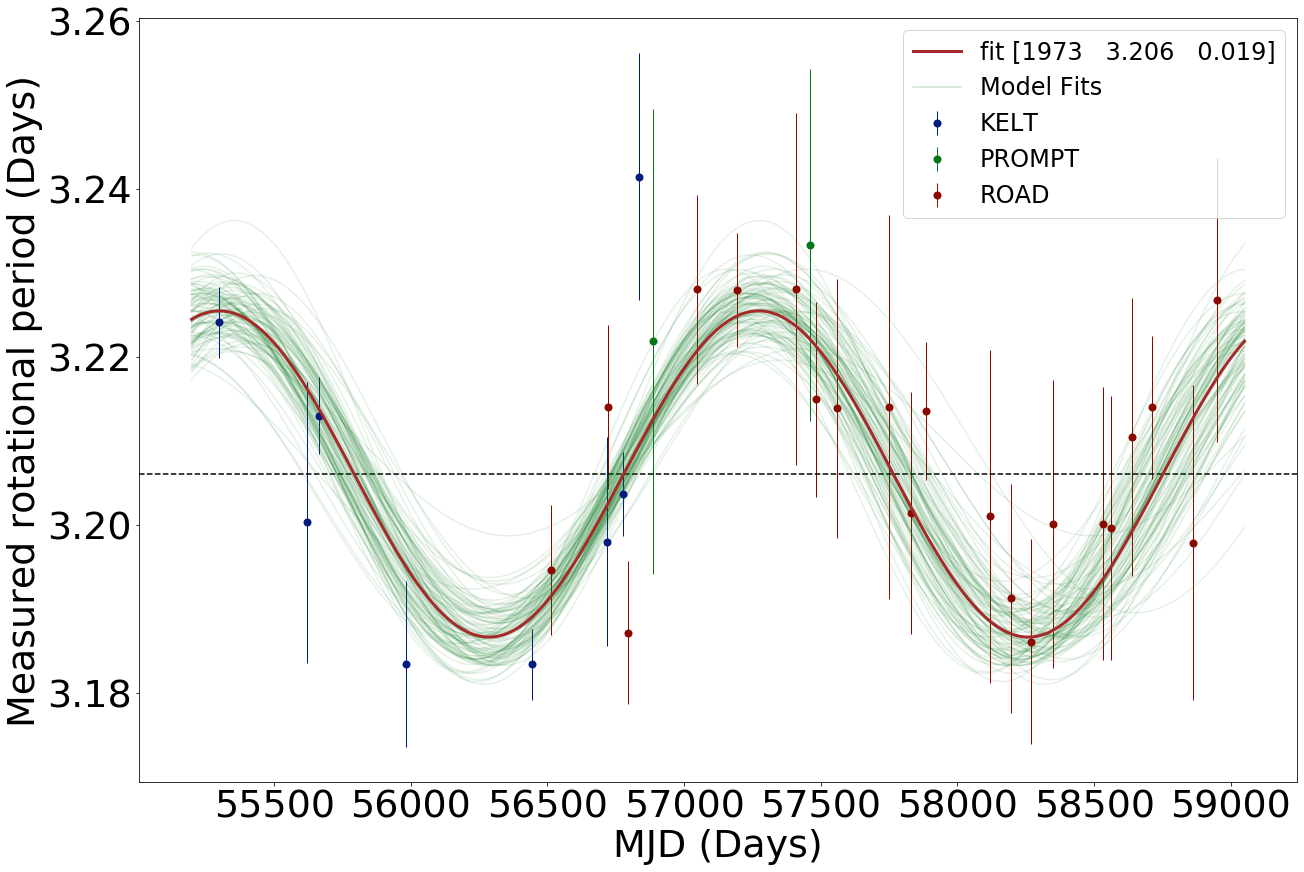

In [141]:
inds = np.random.randint(len(samples), size=100)

font = {'family':'normal', 'weight':'normal', 'size':38}
plt.rc('font', **font)


fig1, f1a = plt.subplots(ncols=1,nrows=1, figsize=(10,6), constrained_layout=True)
colours = ['red', 'black', 'red', 'blue', 'blue', 'yellow']
odd_mask = combined_midpoints < 3.17

for i in range(5): #[ 2, 4]:
    if i > 1:
        f1a.errorbar(sep_midpoints[i],sep_periods[i],yerr=sep_errors[i],fmt='o',capsize=0 ,mew=3, elinewidth=1,ms=5, label=names[i])


a = np.percentile(samples[:, 0], [50])[0]
b = np.percentile(samples[:, 1], [50])[0]
c = np.percentile(samples[:, 2], [50])[0]
d = np.percentile(samples[:, 3], [50])[0]

a_copy = np.copy(a)
b_copy = np.copy(b)
c_copy = np.copy(c)
d_copy = np.copy(d)

    
Pact_model = activity_model(time_space, a, b, c, d)    
    
f1a.plot(time_space,Pact_model,'r-', c= 'brown', linewidth=3,zorder=10, label='fit ['+str(int(a+1))[:4]+"   "+str(c)[:5]+"   "+str(d)[:5]+']')
f1a.axhline(y= np.percentile(samples[:, 2], [50]), linestyle = '--', c='black')
#f1a.errorbar(combined_midpoints[bad_fit_mask], combined_periods[bad_fit_mask], yerr=combined_errors[bad_fit_mask], c = 'black', fmt='o', capsize=0 ,mew=3, elinewidth=1,ms=3, label='Omitted data')

f1a.set_xlabel('MJD (Days)')
f1a.set_ylabel('Measured rotational period (Days)')
for ind in inds:
    onesample = samples[ind]
    P, t0, mean, a = onesample

    # calculate the model with the values in theta, and the data in (t,f,ferr)
    onemodel = activity_model(time_space, P, t0, mean, a) 
    plt.plot(time_space, onemodel, "C1", alpha=0.1)
    if ind == inds[-1]:
        plt.plot(time_space, onemodel, "C1", alpha=0.2, label = 'Model Fits')

figure = plt.gcf()
figure.set_size_inches(18, 12)
    
plt.legend(fontsize = 24)

#f1a.plot(time_space, linear(time_space, *lin_popt), lw = 3)

fig1.savefig('Activity_cycle_16_05.pdf')

Text(0.5, 0, 'sampling')

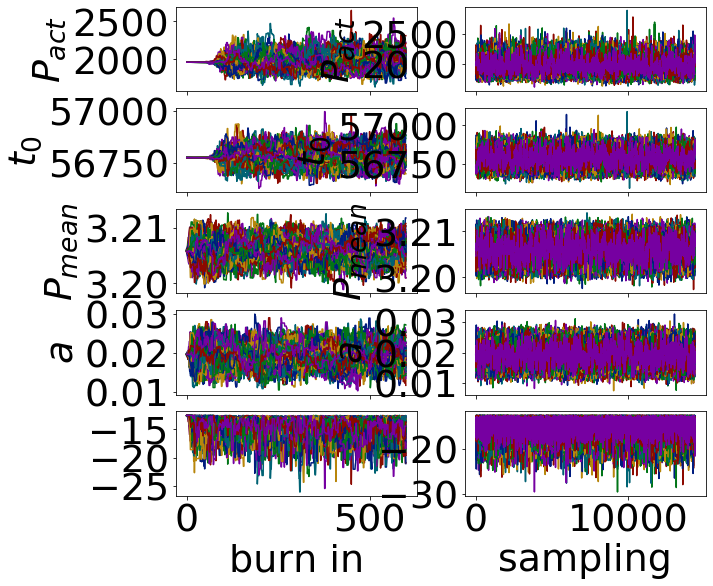

In [51]:
#burn = 600
#fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,9),sharex='col',sharey=False)

#for j in range(nwalkers):
#    ax[-1,0].plot(sampler.lnprobability[j,:burn])
#    for i in range(ndim):
#        ax[i,0].plot(sampler.chain[j,:burn,i])
#        ax[i,0].set_ylabel(labels[i])

#for j in range(nwalkers):
#    ax[-1,1].plot(sampler.lnprobability[j,burn:])
#    for i in range(ndim):
#        ax[i,1].plot(sampler.chain[j,burn:,i])
#        ax[i,1].set_ylabel(labels[i])

#ax[-1,0].set_xlabel('burn in')
#ax[-1,1].set_xlabel('sampling')
#fig.savefig('emcee_burn_3.pdf')

## BIC Test

In [131]:
def bic(n, k, data, model, err):
    wlsq = np.sum((data-model)**2/err**2)
    return n*np.log(wlsq/n)+k*np.log(n)

In [110]:
def linear(x, a, b):
    return a*x+b

[array(1972.80541927), array(56779.16224908), array(3.20604833), array(0.01941812)]
0.0035602725078602818
0.007512933513987119


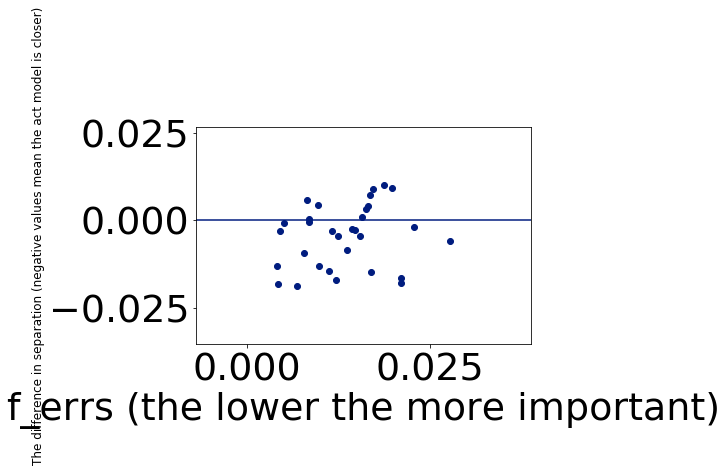

the sinbic is:  7.23
the linbic is:  41.04


In [136]:
f_times, f_means, f_errs = np.concatenate(sep_midpoints), np.concatenate(sep_periods), np.concatenate(sep_errors)

lin_popt, pcov = curve_fit(linear, f_times, f_means, p0 = [0, 3.21], sigma=f_errs, absolute_sigma = True)
sine_popt = [a_copy, b_copy, c_copy, d_copy]
print(sine_popt)

n = len(f_times)
k_sine = 4
k_lin = 2

sin_bic = bic(n, k_sine, f_means, activity_model(f_times, *sine_popt), f_errs)
lin_bic = bic(n, k_lin, f_means, linear(f_times, *lin_popt), f_errs)

plt.scatter(f_errs, abs(f_means-activity_model(f_times, *sine_popt))-abs(f_means-linear(f_times, *lin_popt)))
plt.axhline(y = 0)
plt.xlabel('f_errs (the lower the more important)')
plt.ylabel('The difference in separation (negative values mean the act model is closer)', fontsize = 12)
plt.show()

print("the sinbic is: ", '{0:.2f}'.format(sin_bic))
print("the linbic is: ", '{0:.2f}'.format(lin_bic))